# 02 — Los datos como sistema real

## 0. Introducción

Este notebook tiene un objetivo claro: **aprender a leer los datos como un sistema real**, no como un simple archivo tabular listo para modelar.

En proyectos de machine learning, uno de los errores más comunes es asumir que el dataset **es la realidad**. No lo es.  
Los datos son una **representación incompleta, ruidosa y sesgada** de un proceso real mucho más complejo.

En este punto del proyecto **todavía no buscamos entrenar modelos** ni optimizar métricas.  
Buscamos responder una pregunta previa y crítica:

> ¿Qué tipo de decisiones es razonable apoyar —y cuáles no— con estos datos?

A lo largo de este notebook:

- Analizaremos qué mide realmente el dataset de *Wine Quality*.
- Identificaremos qué información captura y cuál queda fuera.
- Observaremos patrones, desequilibrios y solapamientos.
- Entenderemos por qué ciertos errores serán inevitables, incluso con modelos bien entrenados.

### Qué preguntas **sí** se pueden responder con este dataset

Con estos datos es razonable explorar:

- Relación entre propiedades fisicoquímicas y calidad percibida.
- Tendencias generales y patrones estadísticos.
- Diferencias agregadas entre tipos de vino.
- Zonas del espacio de datos donde las decisiones serán más claras o más ambiguas.

### Qué decisiones **no** se pueden justificar solo con datos

Este dataset **no permite** justificar, por sí solo:

- Decisiones individuales sin margen de error.
- Automatizaciones duras sin revisión humana.
- Inferencias causales fuertes.
- Evaluaciones de calidad como verdad absoluta.

Reconocer estas limitaciones no debilita el análisis.  
Al contrario: **lo hace operativo, responsable y gobernable**.

Este notebook sienta las bases para entender por qué la incertidumbre no es un problema a eliminar,  
sino una propiedad inherente del sistema que más adelante deberá ser **medida, gestionada y respetada**.


---
---
---

## 1. Contexto del dataset

Antes de analizar distribuciones, métricas o entrenar modelos, es fundamental entender **qué es este dataset y qué no es**.

### Origen del dataset *Wine Quality*

El dataset *Wine Quality* proviene de un estudio académico cuyo objetivo era modelar la **calidad percibida del vino** a partir de propiedades fisicoquímicas medibles.  
Incluye dos subconjuntos independientes:

- Vinos tintos (`winequality-red`)
- Vinos blancos (`winequality-white`)

Ambos corresponden al vino portugués *Vinho Verde* y fueron evaluados por expertos humanos.

Este origen académico es clave:  
el dataset fue diseñado para **análisis y experimentación**, no para automatización directa en producción.

### ¿Qué representa cada fila?

Cada fila del dataset representa:

- **Una muestra de vino específica**, analizada en laboratorio.
- Un conjunto de **variables fisicoquímicas objetivas** (pH, alcohol, acidez, sulfatos, etc.).
- Una evaluación de calidad asignada posteriormente por expertos.

No representa:
- Un cliente
- Una marca
- Un contexto de consumo
- Un escenario comercial real

Es una **observación aislada**, fuera de cualquier flujo operativo.

### ¿Qué representa realmente la variable `quality`?

La variable `quality`:

- Es un **score discreto entre 0 y 10**.
- Proviene del **juicio humano**, no de una medición física directa.
- Corresponde a la **mediana** de al menos tres evaluaciones de expertos.

Esto implica algo crítico:

> `quality` no es una verdad objetiva, sino una **opinión agregada**.

Dos vinos con la misma calidad numérica pueden:
- no ser equivalentes sensorialmente,
- haber generado desacuerdo entre expertos,
- estar cerca de un umbral subjetivo.

### Medición objetiva vs juicio humano

En este dataset conviven dos mundos distintos:

**Variables objetivas**
- Medidas instrumentales
- Reproducibles
- Continuas
- Sin interpretación humana directa

**Variable subjetiva (`quality`)**
- Basada en percepción
- Discreta
- Dependiente de criterio humano
- Intrínsecamente ruidosa

Esta diferencia es fundamental para todo el proyecto:

- El modelo aprenderá a mapear **señales objetivas** hacia **juicios humanos**.
- El error no solo es posible: es **inevitable**.
- La incertidumbre no es un fallo del modelo, sino una propiedad del problema.

Este entendimiento será clave cuando más adelante hablemos de:
calibración, thresholds, y decisiones bajo incertidumbre.

---
---
---

## 2. Carga y preparación inicial de los datos

En esta sección realizamos la primera interacción técnica con los datos, pero **sin entrar todavía en modelado**.

El objetivo no es optimizar nada, sino:
- comprender qué datos tenemos,
- cómo se relacionan,
- y qué limitaciones estructurales existen desde el inicio.

### Carga de `winequality-red` y `winequality-white`

El dataset se entrega en dos archivos separados:
- uno para vinos tintos,
- otro para vinos blancos.

Esto ya introduce una decisión analítica importante:  
¿tratamos ambos como problemas distintos o como un solo sistema con variabilidad interna?

Aquí optaremos por **unificarlos**, manteniendo explícita la diferencia entre tipos de vino.

### Unificación y etiquetado de tipos de vino

Para poder analizarlos como un solo sistema:
- añadiremos una variable categórica `wine_type`,
- preservando la información de origen de cada muestra.

Esto nos permitirá:
- comparar distribuciones,
- analizar solapamientos,
- y estudiar si el tipo de vino introduce incertidumbre adicional.

### Tipos de variables disponibles

El dataset contiene exclusivamente:
- variables numéricas continuas (propiedades fisicoquímicas),
- una variable objetivo discreta (`quality`).

No hay:
- variables temporales,
- variables categóricas ricas,
- contexto externo,
- ni metadatos operativos.

### Qué información **no** está presente en el dataset

Es tan importante entender lo que **no está** como lo que sí:

Este dataset **no incluye**:
- información sobre consumidores,
- precio del vino,
- marca o reputación,
- condiciones de consumo,
- contexto cultural,
- variabilidad entre expertos,
- ni nivel de acuerdo/desacuerdo en las evaluaciones.

Estas ausencias impondrán límites claros a cualquier decisión futura:
el modelo solo podrá aprender **lo que los datos permiten observar**.


In [1]:
# Carga inicial de los datasets

import pandas as pd

# Rutas a los archivos
path_red = "../datasets/raw/winequality-red.csv"
path_white = "../datasets/raw/winequality-white.csv"

# Carga de datos
df_red = pd.read_csv(path_red, sep=";")
df_white = pd.read_csv(path_white, sep=";")

# Etiquetar tipo de vino
df_red["wine_type"] = "red"
df_white["wine_type"] = "white"

# Unificar en un solo DataFrame
df = pd.concat([df_red, df_white], ignore_index=True)

In [2]:
# Renombrar columnas a español

column_mapping = {
    "fixed acidity": "acidez_fija",
    "volatile acidity": "acidez_volatil",
    "citric acid": "acido_citrico",
    "residual sugar": "azucar_residual",
    "chlorides": "cloruros",
    "free sulfur dioxide": "dioxido_azufre_libre",
    "total sulfur dioxide": "dioxido_azufre_total",
    "density": "densidad",
    "pH": "ph",
    "sulphates": "sulfatos",
    "alcohol": "alcohol",
    "quality": "calidad",
    "wine_type": "tipo_vino",
}

df = df.rename(columns=column_mapping)

In [3]:
# Vista general
df.head()

,acidez_fija,acidez_volatil,acido_citrico,azucar_residual,cloruros,dioxido_azufre_libre,dioxido_azufre_total,densidad,ph,sulfatos,alcohol,calidad,tipo_vino
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


### **Pregunta 0**

**¿Cuántos registros hay de cada tipo de vino (`tipo_vino`) y qué proporción representan dentro del dataset?**

Este paso permite entender la **composición estructural del dataset** antes de analizar la variable `calidad`.
Conocer el volumen relativo de vinos tintos y blancos es clave para interpretar correctamente distribuciones, porcentajes y cualquier análisis posterior.

In [4]:
# Conteo absoluto por tipo de vino
conteo_por_tipo = df['tipo_vino'].value_counts()

# Porcentaje por tipo de vino
porcentaje_por_tipo = df['tipo_vino'].value_counts(normalize=True) * 100

conteo_por_tipo

tipo_vino
white    4898
red      1599
Name: count, dtype: int64

In [5]:
porcentaje_por_tipo

tipo_vino
white    75.388641
red      24.611359
Name: proportion, dtype: float64

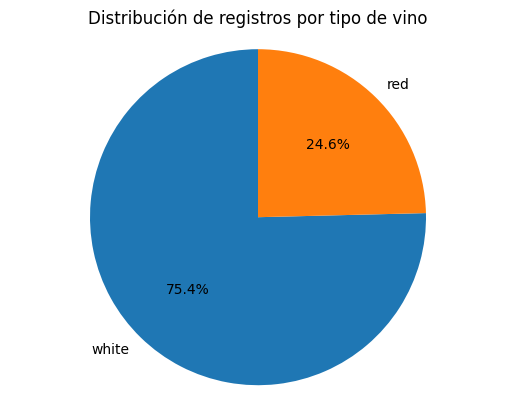

In [6]:
import matplotlib.pyplot as plt

# Gráfica de torta: proporción de vinos por tipo
plt.figure()
plt.pie(
    conteo_por_tipo.values,
    labels=conteo_por_tipo.index,
    autopct='%1.1f%%',
    startangle=90
)
plt.title("Distribución de registros por tipo de vino")
plt.axis('equal')  # Para que sea un círculo perfecto
plt.show()

> El dataset está claramente dominado por vinos blancos.
> Aproximadamente **3 de cada 4 registros** corresponden a vino blanco, mientras que el vino tinto representa **solo una cuarta parte** del total.
> Esto implica que cualquier análisis agregado estará **fuertemente influenciado por el comportamiento del vino blanco** y que las comparaciones entre tipos deben hacerse de forma explícita y separada.

---
---
---

## 3. Exploración de la variable objetivo (`calidad`)

Antes de entrenar cualquier modelo, es imprescindible **entender la variable que se quiere predecir**.  
En este dataset, esa variable es `calidad`, una puntuación discreta asignada por expertos humanos.

### 3.1 ¿Qué representa realmente `calidad`?

- `calidad` es un **juicio sensorial humano**, no una medición física directa.
- Corresponde a la **mediana de al menos tres evaluaciones** realizadas por expertos en vino.
- La escala va de **0 (muy malo) a 10 (excelente)**, aunque en la práctica el rango observado es más reducido.

Esto implica algo clave desde el inicio:
> No estamos prediciendo una verdad objetiva, sino **una percepción agregada**.

### 3.2 Distribución de `calidad`: preguntas que vamos a responder

**Rango y cobertura**
1. ¿Cuál es el valor mínimo y máximo de `calidad` en el dataset completo?
2. ¿Qué valores de `calidad` existen realmente (lista de valores únicos ordenados)?
3. ¿Hay calificaciones en el rango 0–10 que nunca aparecen?

**Frecuencias (dataset completo)**

4. ¿Cuántas observaciones hay por cada valor de `calidad` (conteo)?
5. ¿Cuál es el porcentaje por cada valor de `calidad` (proporción)?
6. ¿Cuál es la moda (la calificación más frecuente)?
7. ¿Qué porcentaje del dataset se concentra en las calidades “intermedias” (ej. 5 y 6)?
8. ¿Qué porcentaje cae en “extremos” (ej. ≤4 y ≥8)?

**Comparación por tipo de vino**

9. ¿Cuál es el mínimo y máximo de `calidad` para vino tinto (`tipo_vino = red`)?
10. ¿Cuál es el mínimo y máximo de `calidad` para vino blanco (`tipo_vino = white`)?
11. ¿Cómo cambia la distribución de `calidad` entre tinto y blanco (conteos y %)?
12. ¿La moda es la misma para tinto y blanco?
13. ¿Qué tipo de vino tiene más presencia en calidades altas (ej. ≥8)?
14. ¿Qué tipo de vino tiene más presencia en calidades bajas (ej. ≤4)?

**Desbalance (lectura operativa)**

15. ¿Qué tan dominante es la clase más frecuente (porcentaje)?
16. ¿Cuántas clases pueden considerarse “raras” bajo un umbral operativo (ej. <5% del dataset)?
17. ¿Qué clases son raras globalmente y cuáles son raras por tipo de vino?

## **Rango y cobertura**

### Pregunta 1  
**¿Cuál es el valor mínimo y máximo de `calidad` en el dataset completo?**

Antes de analizar distribuciones o desbalance, necesitamos conocer el **rango real** de la variable objetivo.  
Esto nos permite entender qué valores existen efectivamente en los datos y descartar supuestos teóricos que no están respaldados por evidencia.

In [7]:
# Valor mínimo y máximo de la variable objetivo 'calidad'
min_calidad = df["calidad"].min()
max_calidad = df["calidad"].max()

min_calidad, max_calidad

(np.int64(3), np.int64(9))

> La variable `calidad` **no cubre todo el rango teórico 0–10**.
> En la práctica, las calificaciones observadas van **de 3 a 9**.
> Esto ya indica que el dataset **no contiene vinos extremos**, ni muy malos ni excelentes absolutos, y que cualquier modelo futuro solo podrá aprender dentro de este rango limitado.

### Pregunta 2  
**¿Qué valores de `calidad` existen realmente (lista de valores únicos ordenados)?**

Conocer los valores únicos nos permite ver si la variable objetivo es:
- continua o discreta,
- densa o fragmentada,
- y qué calificaciones **realmente existen** frente a las que solo existen en teoría.

In [8]:
# Valores únicos de la variable 'calidad', ordenados
valores_calidad = sorted(df["calidad"].unique())

valores_calidad

[np.int64(3),
 np.int64(4),
 np.int64(5),
 np.int64(6),
 np.int64(7),
 np.int64(8),
 np.int64(9)]

> La variable `calidad` toma **valores discretos y consecutivos entre 3 y 9**.
> No hay saltos ni valores aislados, pero tampoco aparecen los extremos teóricos.
> Esto refuerza que estamos modelando **una escala humana acotada**, no una medición continua ni completa.

### Pregunta 3  
**¿Hay calificaciones en el rango 0–10 que nunca aparecen?**

Sí. Aunque la escala teórica de `calidad` va de **0 a 10**, en el dataset **no aparecen los valores 0, 1, 2 ni 10**.  
El rango observado está limitado a **3–9**, lo que refleja cómo los evaluadores humanos utilizan la escala en la práctica.

Esto implica que cualquier modelo entrenado con estos datos **solo puede aprender dentro de ese rango real**, y no puede inferir ni generalizar sobre calidades que nunca fueron observadas.

## **Frecuencias (dataset completo)**

### Pregunta 4  
**¿Cuántas observaciones hay por cada valor de `calidad` (conteo)?**

Para entender si el dataset está balanceado o no, necesitamos ver **cuántos ejemplos reales existen por cada nivel de calidad**.  
Este conteo nos permitirá identificar clases dominantes y clases con poco soporte estadístico.

In [9]:
# Conteo de observaciones por cada valor de 'calidad'
conteo_calidad = df["calidad"].value_counts().sort_index()

conteo_calidad

calidad
3      30
4     216
5    2138
6    2836
7    1079
8     193
9       5
Name: count, dtype: int64

> La distribución es **claramente desigual**.
> Las calidades **5 y 6 dominan el dataset**, mientras que los valores extremos tienen muy poco soporte.
> Casos como `calidad = 9` son **prácticamente anecdóticos**, lo que ya anticipa problemas de aprendizaje y evaluación para esas clases.

### Pregunta 5  
**¿Cuál es el porcentaje por cada valor de `calidad` (proporción)?**

El conteo absoluto muestra el desbalance, pero el **porcentaje** nos permite dimensionar
qué tan dominante es cada clase dentro del total del dataset.

In [10]:
# Porcentaje de observaciones por cada valor de 'calidad'
porcentaje_calidad = (
    df["calidad"]
    .value_counts(normalize=True)
    .sort_index()
    .mul(100)
    .round(2)
)

porcentaje_calidad

calidad
3     0.46
4     3.32
5    32.91
6    43.65
7    16.61
8     2.97
9     0.08
Name: proportion, dtype: float64

> Más del **76% del dataset** se concentra solo en `calidad = 5` y `6`.
> Las calidades extremas representan **menos del 1%** en conjunto.
> Un modelo podría parecer “bueno” simplemente aprendiendo a predecir valores medios, **sin entender realmente los casos raros**.

### Pregunta 6  
**¿Cuál es la moda (la calificación más frecuente)?**

Identificar la moda nos permite ver cuál es el valor que **domina el comportamiento del dataset**  
y anticipar qué tipo de predicción sería favorecida por un modelo ingenuo.

In [11]:
# Moda de la variable 'calidad'
moda_calidad = df["calidad"].mode()

moda_calidad

0    6
Name: calidad, dtype: int64

> La moda del dataset es **`calidad = 6`**.
> Esto significa que la predicción más “segura” desde un punto de vista estadístico sería siempre 6,
> aunque esa estrategia **no aporta valor real** para decisiones más exigentes o casos extremos.

### Pregunta 7  
**¿Qué porcentaje del dataset se concentra en las calidades “intermedias” (5 y 6)?**

Las calidades intermedias (`5` y `6`) concentran **más del 76% del total del dataset**.  
Esto significa que la gran mayoría de los casos representan situaciones “normales”, mientras que los extremos —potencialmente más relevantes para la decisión— están muy poco representados.

En este contexto, un modelo puede aparentar buen desempeño **limitándose a predecir valores medios**, sin aprender a manejar los casos menos frecuentes.

### Pregunta 8  
**¿Qué porcentaje del dataset cae en calidades “extremas” (≤ 4 y ≥ 8)?**

Las calidades extremas representan los casos menos comunes del sistema,  
pero suelen ser los **más relevantes desde el punto de vista de la decisión**  
(por ejemplo, vinos claramente malos o claramente excelentes).

In [12]:
# Porcentaje de calidades extremas (≤4 y ≥8)
extremos = df[df["calidad"].isin([3, 4, 8, 9])]
porcentaje_extremos = round(len(extremos) / len(df) * 100, 2)

porcentaje_extremos

6.83

> Solo **≈ 6.8% del dataset** corresponde a calidades **extremas** (≤ 4 y ≥ 8).
> Es una fracción muy pequeña del total, pero precisamente donde suelen concentrarse las **decisiones más delicadas**.
> Esto refuerza la idea de que el dataset está dominado por lo “normal” y que los extremos tienen **muy poco soporte estadístico**.

## **Comparación por tipo de vino**

### Pregunta 9  
**¿Cuál es el valor mínimo y máximo de `calidad` para el vino tinto (`tipo_vino = red`)?**

Separar el análisis por tipo de vino nos permite entender si el rango de calificaciones
es el mismo para todos los subgrupos o si existen **límites estructurales** según el tipo de producto.

In [13]:
# Mínimo y máximo de 'calidad' para vino tinto
min_max_red = (
    df[df["tipo_vino"] == "red"]["calidad"]
    .agg(["min", "max"])
)

min_max_red

min    3
max    8
Name: calidad, dtype: int64

> En el vino tinto, las calidades observadas van de **3 a 8**.
> No existen vinos tintos con calificación 9 en el dataset, lo que indica que incluso los mejores tintos **no alcanzan el extremo superior** de la escala observada globalmente.
> Esto ya introduce una diferencia estructural frente al vino blanco.

### Pregunta 10  
**¿Cuál es el valor mínimo y máximo de `calidad` para el vino blanco (`tipo_vino = white`)?**

Este análisis permite comparar si el vino blanco comparte el mismo rango de calificaciones
que el vino tinto o si presenta **un comportamiento distinto en los extremos**.

In [14]:
# Mínimo y máximo de 'calidad' para vino blanco
min_max_white = (
    df[df["tipo_vino"] == "white"]["calidad"]
    .agg(["min", "max"])
)

min_max_white

min    3
max    9
Name: calidad, dtype: int64

> En el vino blanco, las calidades observadas van de **3 a 9**.
> A diferencia del vino tinto, aquí **sí aparece el valor máximo** de la escala observada, aunque de forma excepcional.
> Esto refuerza la idea de que los **extremos superiores existen**, pero son raros y están concentrados en un solo tipo de vino.

### **Pregunta 11**

**¿Cómo cambia la distribución de `calidad` entre vino tinto y vino blanco (conteos y porcentajes)?**

Este análisis permite observar si ambos tipos de vino **se comportan de forma similar o diferente** en términos de calidad percibida.
En particular, busca identificar:

* Si uno de los tipos concentra más calificaciones **intermedias** que el otro.
* Si los **extremos** (calidades muy bajas o muy altas) aparecen con distinta frecuencia.
* Si la noción de “vino bueno” o “vino malo” **significa lo mismo** para tinto y blanco dentro del dataset.

La comparación por conteos y porcentajes ayuda a detectar **asimetrías estructurales** que luego impactarán cualquier decisión, métrica o modelo que se construya encima de estos datos.

In [15]:
# Conteo de calificaciones por tipo de vino
conteo_por_tipo = (
    df.groupby(["tipo_vino", "calidad"])
      .size()
      .rename("conteo")
      .reset_index()
)

conteo_por_tipo

,tipo_vino,calidad,conteo
0,red,3,10
1,red,4,53
2,red,5,681
3,red,6,638
4,red,7,199
5,red,8,18
6,white,3,20
7,white,4,163
8,white,5,1457
9,white,6,2198


In [16]:
# Porcentaje de cada calificación dentro de cada tipo de vino
porcentaje_por_tipo = (
    df.groupby("tipo_vino")["calidad"]
      .value_counts(normalize=True)
      .mul(100)
      .rename("porcentaje")
      .reset_index()
)

porcentaje_por_tipo

,tipo_vino,calidad,porcentaje
0,red,5,42.589118
1,red,6,39.899937
2,red,7,12.445278
3,red,4,3.314572
4,red,8,1.125704
5,red,3,0.625391
6,white,6,44.875459
7,white,5,29.746835
8,white,7,17.966517
9,white,8,3.572887


> El vino tinto y el vino blanco **no comparten la misma distribución de calidad**, aunque ambos se concentran en valores intermedios.
>
> En el **vino tinto**, las calificaciones se agrupan casi exclusivamente en **5 y 6**, con muy poca presencia de valores altos y **sin ningún 9**. La cola superior es corta y el “buen vino” es relativamente raro.
>
> En el **vino blanco**, la distribución está más desplazada hacia arriba: hay mayor proporción de **6 y 7**, aparecen más **8** y existe incluso un pequeño número de **9**.
>
> Esto indica que `calidad` **no es directamente comparable** entre tipos de vino: el mismo valor numérico implica **distinto contexto** según sea tinto o blanco.
>
> Cualquier modelo o decisión futura que ignore esta diferencia estará mezclando **regímenes de calidad distintos**.

### Pregunta 12  
**¿La moda (calificación más frecuente) es la misma para el vino tinto y el vino blanco?**

Este análisis busca identificar cuál es la calificación más común en cada tipo de vino.  
La moda representa el valor “normal” o más típico dentro de cada grupo y permite comparar  
si tinto y blanco comparten el mismo centro operativo o si presentan **patrones distintos de normalidad**.

In [17]:
# Moda de la calidad por tipo de vino
df.groupby("tipo_vino")["calidad"].agg(lambda x: x.mode()[0])

tipo_vino
red      5
white    6
Name: calidad, dtype: int64

> La moda **no es la misma** para ambos tipos de vino.
> En el vino **tinto**, la calificación más frecuente es **5**, mientras que en el vino **blanco** es **6**.
> Esto indica que el “caso típico” del dataset **ya depende del tipo de vino**, incluso antes de cualquier modelo.
> La normalidad no es compartida: el punto de referencia cambia según el contexto.

### Pregunta 13  
**¿Qué tipo de vino tiene mayor presencia en calidades altas (≥ 8)?**

Esta pregunta busca identificar **qué tipo de vino domina en los extremos superiores de calidad**, que suelen ser los casos más escasos pero más relevantes.  
Analizar las calidades altas permite anticipar **asimetrías estructurales** entre tinto y blanco que pueden impactar cualquier modelo futuro, especialmente en escenarios donde los “mejores casos” son críticos.

In [18]:
# Filtrar vinos con calidades altas (>= 8)
altas_calidades = df[df["calidad"] >= 8]

# Conteo por tipo de vino
conteo_altas = altas_calidades["tipo_vino"].value_counts()

# Porcentaje por tipo de vino
porcentaje_altas = altas_calidades["tipo_vino"].value_counts(normalize=True) * 100

conteo_altas

tipo_vino
white    180
red       18
Name: count, dtype: int64

In [19]:
porcentaje_altas

tipo_vino
white    90.909091
red       9.090909
Name: proportion, dtype: float64

> A primera vista, el vino blanco domina claramente las calidades altas (≥ 8), concentrando **181 de los 198 casos**.
> Sin embargo, este resultado está **fuertemente influenciado por el tamaño de la muestra**: el dataset contiene muchos más vinos blancos que tintos.
> Esto significa que el mayor número de blancos en calidades altas **no implica necesariamente que el blanco sea “mejor”**, sino que **tiene más oportunidades de aparecer en los extremos**.
> Este es un ejemplo claro de cómo **el desbalance del dataset distorsiona la lectura directa de conteos absolutos**.

### Pregunta 14  
**¿Qué tipo de vino tiene más presencia en calidades bajas (≤ 4)?**

Este análisis busca identificar **cómo se distribuyen los casos de baja calidad entre vino tinto y blanco**.  
Al igual que en las calidades altas, aquí es clave distinguir entre:

- conteos absolutos, y  
- proporciones relativas al tamaño de cada grupo.

Esto nos permitirá evaluar si alguno de los tipos de vino **tiende a concentrar más casos problemáticos** o si el efecto vuelve a estar dominado por el tamaño de la muestra.

In [20]:
# Filtrar calidades bajas
bajas = df[df["calidad"] <= 4]

# Conteo por tipo de vino
conteo_bajas = bajas.groupby("tipo_vino").size()

# Proporción sobre el total de calidades bajas
proporcion_bajas = conteo_bajas / conteo_bajas.sum() * 100

conteo_bajas

tipo_vino
red       63
white    183
dtype: int64

In [21]:
proporcion_bajas

tipo_vino
red      25.609756
white    74.390244
dtype: float64

> En valores de **baja calidad (≤ 4)**, el vino blanco presenta **más casos absolutos** que el vino tinto.
> Sin embargo, este resultado vuelve a estar **fuertemente influenciado por el tamaño de la muestra**, ya que hay muchos más vinos blancos en el dataset.
> En términos relativos, no puede concluirse aún que el vino blanco sea intrínsecamente peor en los extremos bajos; lo que sí queda claro es que **los casos problemáticos existen en ambos tipos**, pero son minoritarios frente al volumen total.

## Resumen — Distribución de la variable `calidad`

El análisis exploratorio de la variable `calidad` deja varias conclusiones claras y operativas:

- La calidad observada **no cubre todo el rango teórico (0–10)**, sino que se concentra entre **3 y 9**.
- La distribución está **fuertemente concentrada en valores intermedios**, especialmente en **5 y 6**, que representan la mayor parte del dataset.
- Las calificaciones extremas (muy bajas o muy altas) son **escasas**, tanto en términos absolutos como relativos.
- El dataset está **desbalanceado por tipo de vino**: el vino blanco representa aproximadamente **tres cuartas partes** de las observaciones.
- La **moda difiere por tipo de vino**:
  - Vino tinto → calidad más frecuente: **5**
  - Vino blanco → calidad más frecuente: **6**
- En calidades altas (≥ 8), el vino blanco domina en número absoluto, pero esto está condicionado por su mayor tamaño muestral.
- En calidades bajas (≤ 4), ambos tipos presentan casos problemáticos, nuevamente con mayor presencia absoluta en vino blanco por volumen de datos.

En conjunto, estos resultados muestran que:

- El problema **no es balanceado**.
- Los casos más interesantes desde el punto de vista de decisión (extremos) son **minoría**.
- Cualquier modelo futuro enfrentará **ruido, solapamiento y escasez de señales claras en los extremos**.

Esto anticipa un punto clave del proyecto:  
**predecir no será lo mismo que decidir**, especialmente cuando los datos reflejan una realidad dominada por la “normalidad”.

## **Desbalance**

### Pregunta 15  
**¿Qué tan dominante es la clase más frecuente (porcentaje)?**

Esta pregunta busca cuantificar **cuánto domina la clase modal** dentro del dataset.  
No es solo saber cuál es la moda, sino **qué fracción del total representa**, para entender:

- Si el problema está fuertemente concentrado en una sola clase.
- Qué tan “fácil” sería obtener buenas métricas triviales.
- Qué nivel de desbalance enfrentará cualquier modelo futuro.

In [22]:
# Porcentaje de la clase más frecuente (dominancia)
dominancia = (
    df["calidad"]
    .value_counts(normalize=True)
    .max() * 100
)

dominancia

np.float64(43.650915807295675)

> La clase más frecuente (`calidad = 6`) concentra **aproximadamente el 44%** de todas las observaciones.
> Esto significa que **casi la mitad del dataset está en una sola clase**, lo que confirma un desbalance claro.
> Un modelo trivial que siempre predijera esta clase parecería “bueno” en métricas simples,
> pero sería **operativamente pobre** para detectar casos fuera de lo normal.

### Pregunta 16  
**¿Cuántas clases pueden considerarse “raras” bajo un umbral operativo (< 5% del dataset)?**

Definimos como *clases raras* aquellas calificaciones cuya proporción es inferior al **5%** del total.
Este criterio no es estadístico, es **operativo**: identifica clases con **poca evidencia empírica**
y mayor riesgo de error o inestabilidad en modelos futuros.

In [23]:
# Proporción por clase de calidad
proporcion_por_clase = (
    df["calidad"]
    .value_counts(normalize=True)
    .sort_index() * 100
)

# Clases raras bajo umbral operativo
clases_raras = proporcion_por_clase[proporcion_por_clase < 5]

clases_raras, len(clases_raras)

(calidad
 3    0.461752
 4    3.324611
 8    2.970602
 9    0.076959
 Name: proportion, dtype: float64,
 4)

> Bajo un umbral operativo del **5%**, existen **4 clases raras**: **3, 4, 8 y 9**.
> Estas clases aparecen muy pocas veces en el dataset y, por tanto, cualquier modelo tendrá **menos evidencia** para aprender sobre ellas.
> En la práctica, son justamente estas clases las que suelen generar **más incertidumbre y mayor riesgo** en decisiones automatizadas.

### Pregunta 17  
**¿Qué clases son raras globalmente y cuáles son raras por tipo de vino?**

Esta pregunta busca distinguir entre dos cosas distintas pero relacionadas:

- **Rareza global**: clases que son poco frecuentes en todo el dataset.
- **Rareza condicionada**: clases que pueden no ser tan raras en general, pero sí lo son dentro de un tipo específico de vino.

Esta distinción es clave porque un modelo puede parecer “razonable” a nivel global,
pero comportarse de forma **frágil o sesgada** cuando se analiza por subgrupos.

In [24]:
# Umbral operativo de rareza
umbral = 5  # porcentaje

# Rareza global
rareza_global = (
    df['calidad']
    .value_counts(normalize=True)
    .mul(100)
    .reset_index(name='porcentaje')
    .rename(columns={'index': 'calidad'})
)

rareza_global[rareza_global['porcentaje'] < umbral]

,calidad,porcentaje
3,4,3.324611
4,8,2.970602
5,3,0.461752
6,9,0.076959


In [25]:
# Rareza por tipo de vino
rareza_por_tipo = (
    df
    .groupby('tipo_vino')['calidad']
    .value_counts(normalize=True)
    .mul(100)
    .reset_index(name='porcentaje')
)

rareza_por_tipo[rareza_por_tipo['porcentaje'] < umbral]

,tipo_vino,calidad,porcentaje
3,red,4,3.314572
4,red,8,1.125704
5,red,3,0.625391
9,white,8,3.572887
10,white,4,3.327889
11,white,3,0.408330
12,white,9,0.102082


> **Rareza global:** las calidades **3, 4, 8 y 9** son raras en el dataset completo (todas por debajo del 5%).
> Esto confirma que los extremos —tanto bajos como altos— están **muy poco representados** frente a las calidades intermedias.

> **Rareza por tipo de vino:**
>
> * En **vino tinto**, las calidades **3, 4 y 8** son raras, y el extremo alto está especialmente subrepresentado.
> * En **vino blanco**, las calidades **3, 4, 8 y 9** son raras, aunque el blanco sí alcanza el valor máximo 9, pero de forma marginal.

> Conclusión clave:
> La rareza **no es uniforme**. Una clase puede ser rara globalmente y aún más frágil cuando se analiza por tipo de vino.
> Esto anticipa problemas de aprendizaje, evaluación y toma de decisiones si se ignora la estructura del dataset.

---

## 3.3 Visualización del desbalance de `calidad` (vista ejecutiva)

Hasta ahora ya vimos los conteos y porcentajes.  
Ahora lo vamos a **hacer obvio visualmente**: qué calidades dominan y cuáles son marginales.

Vamos a graficar:
- Distribución global de `calidad` (conteo)
- Distribución global de `calidad` (porcentaje)

Esto nos deja una “foto” rápida del desbalance antes de entrar en cualquier modelado.

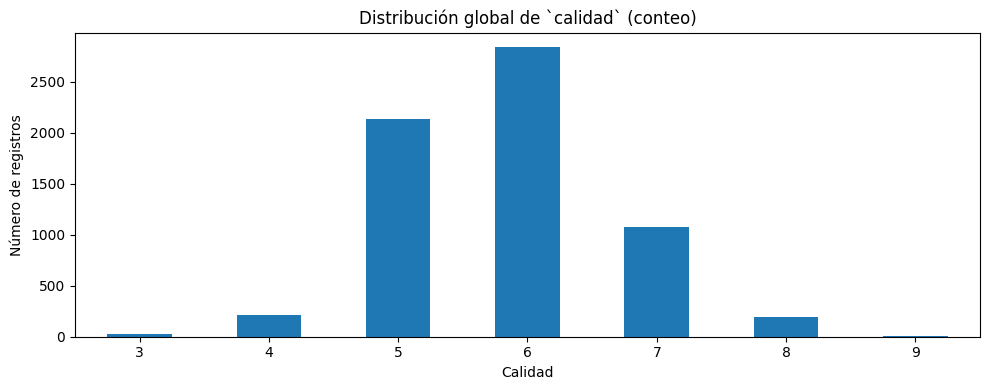

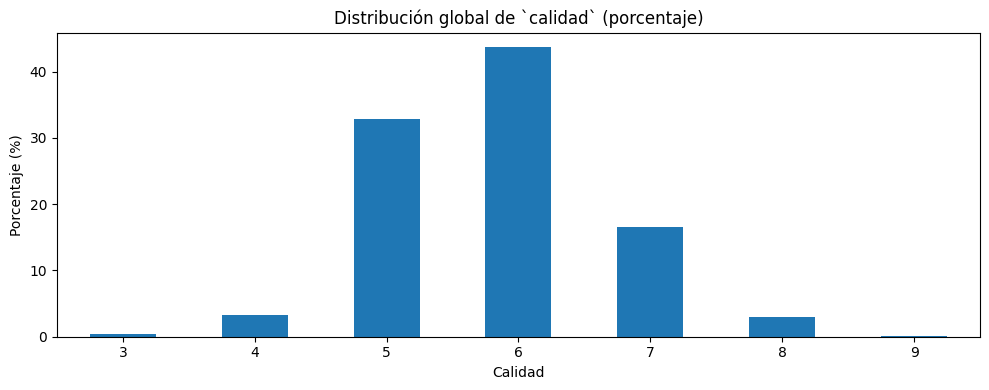

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Conteo global por calidad (ordenado)
conteo_calidad = df["calidad"].value_counts().sort_index()

plt.figure(figsize=(10, 4))
conteo_calidad.plot(kind="bar")
plt.title("Distribución global de `calidad` (conteo)")
plt.xlabel("Calidad")
plt.ylabel("Número de registros")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# 2) Porcentaje global por calidad (ordenado)
pct_calidad = (conteo_calidad / conteo_calidad.sum() * 100).round(2)

plt.figure(figsize=(10, 4))
pct_calidad.plot(kind="bar")
plt.title("Distribución global de `calidad` (porcentaje)")
plt.xlabel("Calidad")
plt.ylabel("Porcentaje (%)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

---
---
---

## 4. Representatividad del dataset

El dataset *Wine Quality* no pretende representar **todo el universo del vino**, sino un recorte muy específico de la realidad.

A partir del análisis realizado, podemos afirmar que:

- Las **calidades medias** (5 y 6) están ampliamente representadas.
- Los casos **extremos** (vinos muy malos o muy buenos) existen, pero son escasos.
- La mayoría de las observaciones corresponden a vinos **normales**, no excepcionales.

Esto implica que el dataset es fuerte para:
- Aprender patrones generales.
- Modelar comportamientos promedio.
- Entender qué caracteriza a un vino “típico”.

Pero es débil para:
- Aprender con precisión sobre casos raros.
- Generalizar con confianza en los extremos.
- Justificar decisiones automáticas en situaciones poco frecuentes.

Este desbalance **no es un defecto del dataset**.  
Es una **propiedad del sistema real** que estamos observando:

> En la realidad, lo común ocurre mucho más que lo excepcional.

Una consecuencia directa es que:
- La frecuencia de una clase está relacionada con el **nivel de incertidumbre**.
- Donde hay pocos datos, habrá inevitablemente **más duda**.
- Y donde hay más duda, automatizar sin cuidado es riesgoso.

---

## 5. Pregunta de cierre antes del modelo

Antes de entrenar cualquier modelo, este análisis nos obliga a hacernos una última pregunta clave:

**¿Qué puede hacer razonablemente un modelo entrenado con estos datos?**

La respuesta honesta es:

- Puede **producir señales útiles** sobre la calidad probable de un vino.
- Puede **ordenar casos**, comparar perfiles y detectar patrones generales.
- Puede ayudar a **priorizar atención**, no a reemplazar el juicio humano.

Lo que **no** puede ni debe prometer:

- Certeza absoluta.
- Decisiones perfectas en los extremos.
- Automatización ciega sin contexto adicional.

Este punto marca un cambio importante en la forma de pensar el proyecto:

> El modelo no será un decisor.  
> Será un **productor de señales bajo incertidumbre**.

Con esta idea clara, estamos listos para avanzar al siguiente notebook,  
donde por primera vez entrenaremos modelos —  
no para decidir, sino para **entender qué señales son capaces de emitir**.

➡️ **Siguiente notebook:** `03_models_produce_signals.ipynb`